**Random Forest (RF)**

In [4]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 46.5 MB/s eta 0:00:00


In [5]:
import numpy as np

In [6]:
# Load the data from drive
data_array = np.load('/content/drive/My Drive/data_array.npy')
label_array = np.load('/content/drive/My Drive/label_array.npy')
group_array = np.load('/content/drive/My Drive/group_array.npy')
features_array = np.load('/content/drive/My Drive/features_array.npy')

print(data_array.shape, label_array.shape, group_array.shape,features_array.shape)

(6843, 19, 1250) (6843,) (6843,) (6843, 551)


# ML Model

In [2]:
!pip install scikit-learn

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
# Define Random Forest Classifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1)

# Define Group K-Fold
gkf = GroupKFold(n_splits=5)

# Define pipeline with standardization
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Scale features before feeding into Random Forest
    ('clf', clf)
])

# Define hyperparameter grid for optimization
param_grid = {
    'clf__n_estimators': [80, 100, 120],  # Number of trees
    'clf__max_depth': [15, 20, 25],  # Tree depth (None = full growth)
    'clf__min_samples_split': [2, 3],  # Minimum samples to split a node
    'clf__min_samples_leaf': [1, 2],  # Minimum samples per leaf
    'clf__max_features': ['sqrt', 'log2'],  # Number of features to consider for best split
}

# Perform Grid Search with GroupKFold
gscv = GridSearchCV(
    pipe, param_grid, cv=gkf, n_jobs=-1, verbose=1
)

# Train the model
gscv.fit(features_array, label_array, groups=group_array)




Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(class_weight='balanced',
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [15, 20, 25],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [2, 3],
                         'clf__n_estimators': [80, 100, 120]},
             verbose=1)

In [12]:
# Print best parameters and score
print("Best Parameters:", gscv.best_params_)
print("Best Score:", gscv.best_score_)
best_model = gscv.best_estimator_

Best Parameters: {'clf__max_depth': 15, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 120}
Best Score: 0.5766446362971935


# Classification report and Confusion matrix  

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      3183
           1       0.60      0.60      0.60      3660

    accuracy                           0.57      6843
   macro avg       0.57      0.57      0.57      6843
weighted avg       0.57      0.57      0.57      6843



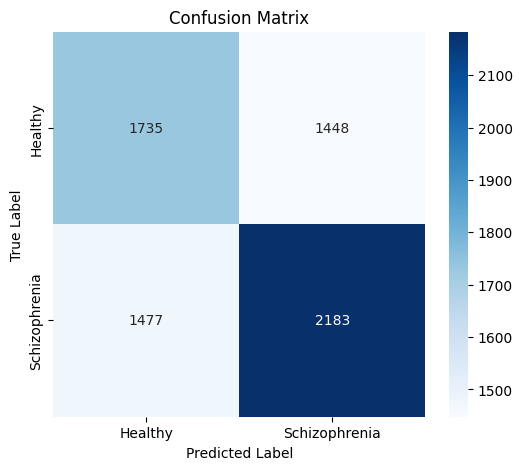

In [13]:
# Initialize arrays for storing results
y_true_all = []
y_pred_all = []

# Perform GroupKFold cross-validation manually with the best model
for train_idx, test_idx in gkf.split(features_array, label_array, groups=group_array):
    # Split data
    X_train, X_test = features_array[train_idx], features_array[test_idx]
    y_train, y_test = label_array[train_idx], label_array[test_idx]

    # Fit the best model on training data
    best_model.fit(X_train, y_train)

    # Predict on test data
    y_pred = best_model.predict(X_test)

    # Store true and predicted labels
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Convert lists to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

# Compute classification report
print("Classification Report:")
print(classification_report(y_true_all, y_pred_all))

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Schizophrenia"], yticklabels=["Healthy", "Schizophrenia"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()